# Exploratory Data Analysis

In [239]:
# Define some exclusions for PEP8 that don't apply when the Jupyter Notebook
#   is exported to .py file
# pylint: disable=pointless-statement
# pylint: disable=fixme
# pylint: disable=expression-not-assigned
# pylint: disable=missing-module-docstring
# pylint: disable=invalid-name

import os
import importlib
import math

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from   sklearn.preprocessing import StandardScaler

import saleslib                         # my custom one
importlib.reload(saleslib)
from saleslib import LABEL_COLUMN_NAME, RANDOM_STATE

saleslib.initialize_random_seeds()
saleslib.initialize_display_options()

### Load the data into a Pandas dataframe

In [240]:
input_filepath = os.path.join('data', 'raw_CRM_opps_export-dummydata.csv')
df_raw = saleslib.load_data_raw(input_filepath)
df_basic_cleanup = saleslib.load_sales_data_cleaned(input_filepath)

df_winsorized = (df_basic_cleanup.
                pipe(saleslib.start_pipeline).
                pipe(saleslib.winsorize_cols)
)

df_norm = (df_winsorized.
            pipe(saleslib.start_pipeline).
            pipe(saleslib.normalize_cols_to_fixed_range)
).copy()

df_full_pipeline = saleslib.full_pipeline(df_raw).copy()
y_full_pipeline        = df_full_pipeline[LABEL_COLUMN_NAME]
X_full_pipeline        = df_full_pipeline.drop(columns=LABEL_COLUMN_NAME, axis=1)


# Standardize the data
sc       = StandardScaler()
X_standardized = sc.fit_transform(X_full_pipeline)
# print(type(X_standardized))
df_standardized = pd.concat([pd.DataFrame(X_standardized,columns = X_full_pipeline.columns), y_full_pipeline])

# df_standardized.columns

## Common statistics for entire dataframe

In [241]:
# store the number of rows for use below
# num_rows = df_basic_cleanup.shape[0]

# include non-numeric columns and other statistical data too:
df_basic_cleanup.describe(include='all')

Age of opp in days CRM Identifier  Deal size (USD)  Industry  \
count               8486.0           8486      8486.000000      8417   
unique                <NA>           8486              NaN        13   
top                   <NA>    opp_4f70539              NaN  Services   
freq                  <NA>              1              NaN      1823   
mean            133.168277            NaN     46014.863186       NaN   
std             119.560638            NaN     44730.531910       NaN   
min                   14.0            NaN      1500.000000       NaN   
25%                   48.0            NaN     12375.000000       NaN   
50%                   96.0            NaN     31468.000000       NaN   
75%                  178.0            NaN     66000.000000       NaN   
max                  720.0            NaN    424287.000000       NaN   

        Num times opp pushed Sales Rep ID Sales team name       Won  \
count                 8486.0         8486            8486    8486.0   
unique                  <NA>          271              13      <NA>   
top                     <NA>  rep_49d39a4  West - Rockies      <NA>   
freq                    <NA>          191             832      <NA>   
mean                1.952864          NaN             NaN  0.234268   
std                 1.893298          NaN             NaN  0.423566   
min                      0.0          NaN             NaN       0.0   
25%                      1.0          NaN             NaN       0.0   
50%                      1.0          NaN             NaN       0.0   
75%                      3.0          NaN             NaN       0.0   
max                     14.0          NaN             NaN       1.0   

        quarter_created  quarter_closed  partner_involved  \
count            8486.0          8486.0            8486.0   
unique             <NA>            <NA>              <NA>   
top                <NA>            <NA>              <NA>   
freq               <NA>            <NA>              <NA>   
mean           2.430592        2.514612          0.377681   
std            1.101914        1.135265          0.484836   
min                 1.0             1.0               0.0   
25%                 1.0             1.0               0.0   
50%                 2.0             2.0               0.0   
75%                 3.0             4.0               1.0   
max                 4.0             4.0               1.0   

       positioning_category product_family hosting_location sales_territory  
count                  5935           5935             5935            8486  
unique                    4              8                4               3  
top                 product              C    saas_platform            West  
freq                   3859           2574             3474            3106  
mean                    NaN            NaN              NaN             NaN  
std                     NaN            NaN              NaN             NaN  
min                     NaN            NaN              NaN             NaN  
25%                     NaN            NaN              NaN             NaN  
50%                     NaN            NaN              NaN             NaN  
75%                     NaN            NaN              NaN             NaN  
max                     NaN            NaN              NaN             NaN

# Class Balance for Label
Investigates the class balance for the label as it goes through the data pipeline.

Also defines the log loss threshold that determines if the model is quality.

In [242]:
class_balance_orig    = saleslib.get_class_balance(df_raw)
dumb_log_loss_orig    = saleslib.calculate_log_loss(class_balance_orig)
print(f'Original class balance: {class_balance_orig}; dumb log loss: {dumb_log_loss_orig}')

class_balance_cleaned = saleslib.get_class_balance(df_basic_cleanup)
dumb_log_loss_cleaned = saleslib.calculate_log_loss(class_balance_cleaned)
print(f'Cleaned class balance: {class_balance_cleaned}; dumb log loss: {dumb_log_loss_cleaned}')

Original class balance: [0.7384550354010356, 0.26154496459896437]; dumb log loss: 0.574620030039681
Cleaned class balance: [0.765731793542305, 0.23426820645769503]; dumb log loss: 0.5444201033034874


In [243]:
# Counting the number of won and lost opps in the original dataset
opps_won, opps_lost, win_ratio, num_losses, num_wins, total_opps = saleslib.calc_win_loss_data(df_raw)

# Plotting the Wins/Losses as a function of Opp Age
in various stages of data pipeline

if there's an error in the first plot, it's because the ```%matplotlib widget``` command below has a bug.

Text(0, 0.5, 'Number of Opps')

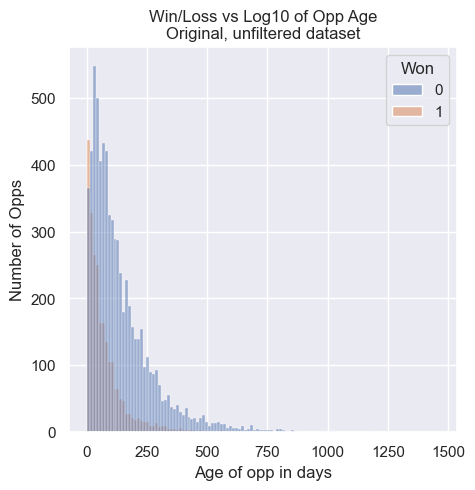

In [244]:
p0 = sns.histplot(data=df_raw, x='Age of opp in days', hue=LABEL_COLUMN_NAME) # , binwidth=30)
p0.set_title('Win/Loss vs Log10 of Opp Age\nOriginal, unfiltered dataset')
p0.set_ylabel('Number of Opps')

Text(0, 0.5, 'Number of Opps')

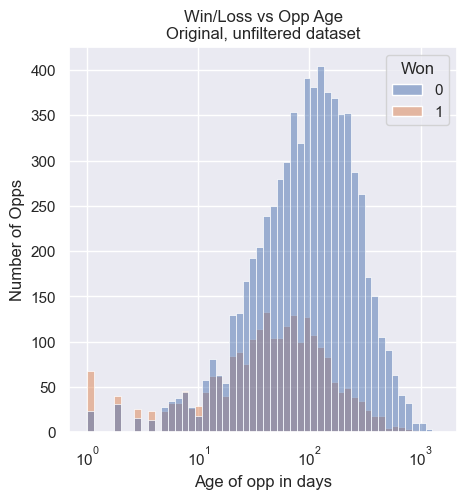

In [245]:
p1 = sns.histplot(data=df_raw, x='Age of opp in days', hue=LABEL_COLUMN_NAME, log_scale=True)
p1.set_title('Win/Loss vs Opp Age\nOriginal, unfiltered dataset')
p1.set_ylabel('Number of Opps')

Text(0, 0.5, 'Number of Opps')

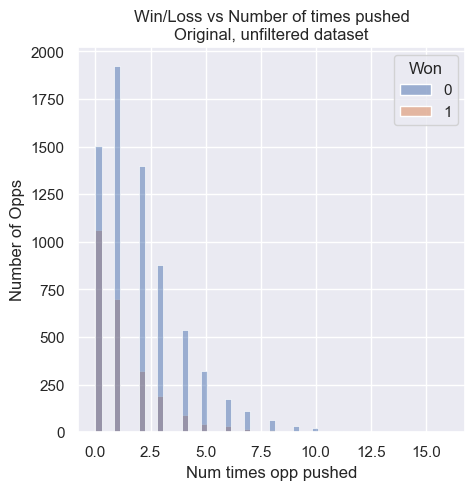

In [246]:
p4 = sns.histplot(data=df_raw, x='Num times opp pushed', hue=LABEL_COLUMN_NAME)
p4.set_title('Win/Loss vs Number of times pushed\nOriginal, unfiltered dataset')
p4.set_ylabel('Number of Opps')

Text(0.5, 1.0, 'Win/Loss in first 30 days\nOriginal, unfiltered dataset')

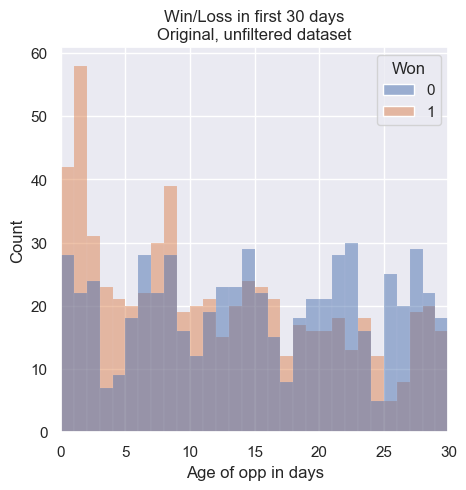

In [247]:
# looking for opps that were probably just made for quoting
# There's a bump at day 1 and day 8 after the opp was opened, when it never pushed
p5 = sns.histplot(data=df_raw[df_raw['Num times opp pushed'] == 0], x='Age of opp in days', hue=LABEL_COLUMN_NAME, binwidth=1)
p5.set_xlim(0, 30)
p5.set_title('Win/Loss in first 30 days\nOriginal, unfiltered dataset')

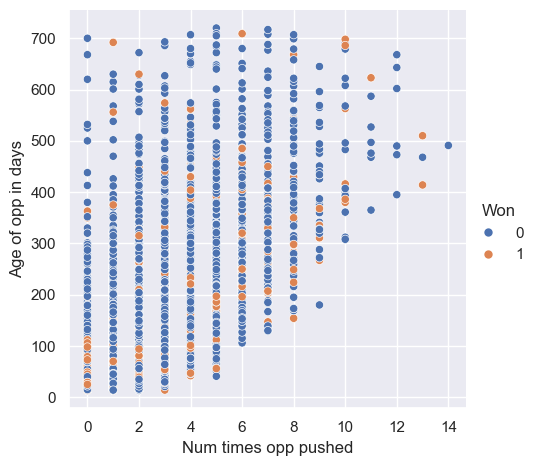

In [248]:
# TODO: prob better as a heat map?
p6 = sns.relplot(data=df_basic_cleanup, x="Num times opp pushed", y="Age of opp in days", hue="Won")
#p6.set_title('Win/Loss as a function of Age and Pushes\nCleaned up dataset')   # not

# Locating Missing Values 
Count the number of rows with missing values, ordered by most to fewest missing values

In [249]:
saleslib.get_columns_with_missing_values(df_raw)

Industry    78
dtype: int64

# Unique string values in columns
Displays dict that lists each column's unique string values and the row count for each one.

In [250]:
saleslib.list_unique_string_values(df_basic_cleanup)

{'Industry': {'Technology': 1122,
  'Finance': 1555,
  'Utilities & Energy': 164,
  'Other Industry': 98,
  'Manufacturing': 965,
  'Healthcare': 828,
  'Retail': 887,
  'Communications & Media': 605,
  'Services': 1823,
  'Education': 53,
  'Transportation': 152,
  'Real Estate': 111,
  'Government': 54,
  '_None_': 69},
 'Sales team name': {'Central - South 1': 513,
  'Central - North': 561,
  'Central - Midwest': 740,
  'West - North 1': 626,
  'East - North': 450,
  'East - Mid-Atlantic': 622,
  'Central - Texas': 638,
  'East - NYC': 662,
  'West - Bay Area': 819,
  'West - South': 829,
  'East - Tri-State': 623,
  'West - Rockies': 832,
  'East - South': 571,
  '_None_': 0},
 'positioning_category': {'product': 3859,
  'managed_service': 1630,
  'unclear': 398,
  'limited_service_engagement': 48,
  '_None_': 2551},
 'product_family': {'C': 2574,
  'B': 2041,
  'D': 261,
  'A': 442,
  'E': 205,
  'Q': 105,
  'F': 259,
  'W': 48,
  '_None_': 2551},
 'hosting_location': {'saas_platf

# Feature correlation with label

In [251]:
list_of_pipeline_steps = [df_raw, df_basic_cleanup, df_winsorized, df_norm, df_full_pipeline]
for dd in list_of_pipeline_steps:
    varname = saleslib.get_variable_name(dd,namespace=globals())
    print(f'\n\n============== {varname} ==============')
    print(saleslib.feature_target_correlation(dd))



============== dd ==============
Age of opp in days     -0.211715
Num times opp pushed   -0.186357
Deal size (USD)        -0.061553
dtype: float64


============== df_basic_cleanup ==============
Age of opp in days     -0.185070
Num times opp pushed   -0.148329
partner_involved        0.121190
quarter_closed          0.034301
Deal size (USD)        -0.019223
quarter_created         0.004541
dtype: float64


============== df_winsorized ==============
Age of opp in days     -0.198704
Num times opp pushed   -0.159801
partner_involved        0.121190
quarter_closed          0.034301
Deal size (USD)        -0.020763
quarter_created         0.004541
dtype: float64


============== dd ==============
Age of opp in days     -0.198704
Num times opp pushed   -0.159801
partner_involved        0.121190
quarter_closed          0.034301
Deal size (USD)        -0.020763
quarter_created         0.004541
dtype: float64


============== dd ==============
Age of opp in days             -0.230854
Num ti

/opt/homebrew/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/homebrew/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [252]:
saleslib.feature_target_correlation(df_full_pipeline).head(15)

/opt/homebrew/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/homebrew/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Age of opp in days                    -0.230854
Num times opp pushed                  -0.173511
partner_involved                       0.151635
product_family_B                       0.148550
positioning_category_unclear           0.120486
hosting_location_saas_platform         0.102503
positioning_category_product           0.091329
hosting_location_                      0.078352
product_family_C                       0.062032
product_family_F                      -0.046551
Sales Rep ID_rep_a8bc765               0.043021
Sales Rep ID_rep_bf1275e              -0.042746
Sales Rep ID_rep_5ad3489              -0.041026
Sales team name_West - Rockies         0.040908
hosting_location_legacy_acquisition   -0.037499
dtype: float64

In [253]:
#saleslib.feature_target_correlation(df_standardized)

# Data Leakage
Investigating features that correlate with each other. Label excluded.

In [254]:
list_of_pipeline_steps = [df_raw, df_basic_cleanup, df_winsorized, df_norm]
for dd in list_of_pipeline_steps:
    varname = saleslib.get_variable_name(dd,namespace=globals())
    print(f'\n\n===================== {varname} ========================')
    print(saleslib.data_leakage(dd).to_string(index=False,col_space=25))



===================== dd ========================
              Correlation                 Feature A                 Feature B
                 0.673902        Age of opp in days      Num times opp pushed
                 0.117271        Age of opp in days           Deal size (USD)
                 0.112018           Deal size (USD)      Num times opp pushed


===================== df_basic_cleanup ========================
              Correlation                 Feature A                 Feature B
                 0.663744        Age of opp in days      Num times opp pushed
                 0.152666      Num times opp pushed          partner_involved
                 0.099559        Age of opp in days           Deal size (USD)
                 0.089746            quarter_closed           quarter_created
                 0.088472           Deal size (USD)      Num times opp pushed
                 0.063609           Deal size (USD)          partner_involved
                -0.03438

/Users/the-molecular-man/source_code/portfolio-private/sales_prediction_modeling/saleslib/__init__.py:342: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_dataleakage = pd.concat([df_dataleakage, pd.DataFrame([new_entry])], ignore_index=True)
/Users/the-molecular-man/source_code/portfolio-private/sales_prediction_modeling/saleslib/__init__.py:342: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_dataleakage = pd.concat([df_dataleakage, pd.DataFrame([new_entry])], ignore_index=True)
/Users/the-m

In [275]:
print(saleslib.data_leakage(df_norm).to_string(index=False,col_space=25))

              Correlation                 Feature A                 Feature B
                 0.671506        Age of opp in days      Num times opp pushed
                 0.152742      Num times opp pushed          partner_involved
                 0.103906        Age of opp in days           Deal size (USD)
                 0.089746            quarter_closed           quarter_created
                 0.083516           Deal size (USD)      Num times opp pushed
                 0.064871           Deal size (USD)          partner_involved
                -0.035474      Num times opp pushed            quarter_closed
                 0.014212        Age of opp in days           quarter_created
                 0.013546      Num times opp pushed           quarter_created
                 0.013182           Deal size (USD)           quarter_created
                -0.012805          partner_involved           quarter_created
                 0.011491          partner_involved            q

/Users/the-molecular-man/source_code/portfolio-private/sales_prediction_modeling/saleslib/__init__.py:342: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_dataleakage = pd.concat([df_dataleakage, pd.DataFrame([new_entry])], ignore_index=True)


In [255]:
saleslib.data_leakage(df_full_pipeline).to_string(index=False,col_space=25)

/Users/the-molecular-man/source_code/portfolio-private/sales_prediction_modeling/saleslib/__init__.py:342: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_dataleakage = pd.concat([df_dataleakage, pd.DataFrame([new_entry])], ignore_index=True)


'              Correlation                                       Feature A                                       Feature B\n                 1.000000 positioning_category_limited_service_engagement                                product_family_W\n                 1.000000                        hosting_location_on_prem                                product_family_Q\n                 0.946599             hosting_location_legacy_acquisition                                product_family_F\n                 0.912315                  hosting_location_saas_platform                    positioning_category_product\n                 0.838603                               hosting_location_            positioning_category_managed_service\n                 0.676719                              Age of opp in days                            Num times opp pushed\n                 0.626554            positioning_category_managed_service                                product_family_C\n               

# PCA

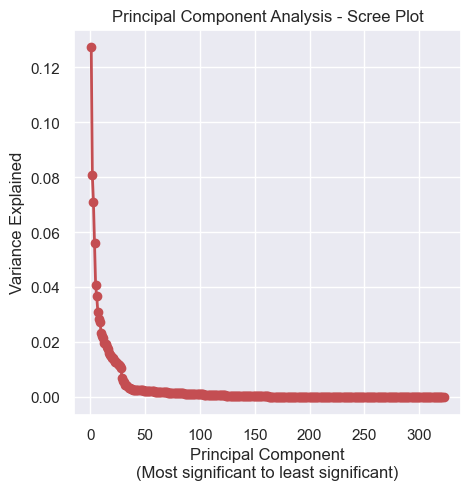

In [256]:
df_ONE = saleslib.full_pipeline(df_raw)
plot_handle, pca = saleslib.get_PCA(df_ONE)

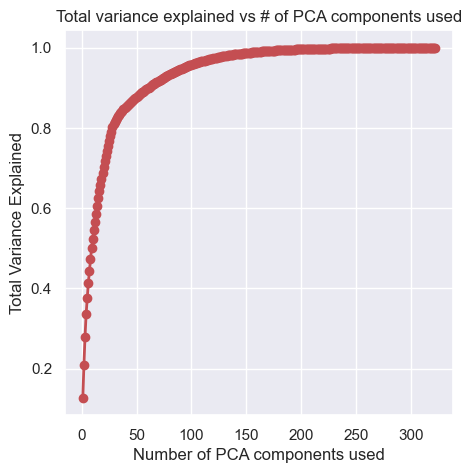

In [257]:
cum_var_exp = np.cumsum(pca.explained_variance_ratio_)
#x_axis = range(1,len(cum_var_exp))

plot_handle = plt.plot(range(1,len(cum_var_exp)+1), cum_var_exp, 'ro-', linewidth=2)
plt.title('Total variance explained vs # of PCA components used')
plt.xlabel('Number of PCA components used')
plt.ylabel('Total Variance Explained')
plt.show()

In [258]:
def find_nearest_index(array,value):
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx

for i in range(10,100, 10):
    num_components = int(find_nearest_index(cum_var_exp, i/100.0) + 1)
    print(f'{num_components} components explains {i}% of the total variance' )

1 components explains 10% of the total variance
2 components explains 20% of the total variance
3 components explains 30% of the total variance
6 components explains 40% of the total variance
9 components explains 50% of the total variance
14 components explains 60% of the total variance
20 components explains 70% of the total variance
28 components explains 80% of the total variance
61 components explains 90% of the total variance


In [259]:
# %matplotlib widget        # this causes issues with rerunning without restarting the kernel
#saleslib.plot_PCA_3D(df_norm)

# Experiment 1 - PCA & Correlations on the raw data with several dropped features
Dropping several features that have low correlation with the label, and one that has high correlation with another feature

In [260]:
# df_exp1 = df_basic_cleanup.drop(columns=['Num times opp pushed', 'quarter_closed', 'Deal size (USD)', 'quarter_created'])

In [261]:
# saleslib.data_leakage(df_exp1)

In [262]:
# saleslib.feature_target_correlation(df_exp1)

In [263]:
# scree_plot_exp1, pca_exp1 = saleslib.get_PCA(df_exp1)

# Experiment 2 - PCA & Correlations on the mid-data with several dropped features

In [264]:
# df_exp2 = saleslib.full_pipeline(df_raw)
# # df_exp2.drop(columns=['Num times opp pushed', 'quarter_closed', 'Deal size (USD)', 'quarter_created'], inplace=True)
# saleslib.data_leakage(df_exp2)

In [265]:
# exp2_ftc = saleslib.feature_target_correlation(df_exp2)

# exp2_ftc.head(50)

In [266]:
# scree_plot_exp2, pca_exp2 = saleslib.get_PCA(df_exp2)

# Experiment 3 - Keeping on the top X features

In [267]:
# NUM_TOP_CORR_FEAT_TO_KEEP = 25
# #df_exp3 = exp2_ftc
# exp3_columns_to_keep = exp2_ftc[0:NUM_TOP_CORR_FEAT_TO_KEEP].index.to_list()
# get_most_label_correlated_features()

In [268]:
# keep_columns = saleslib.get_most_label_correlated_features(df_exp2, 20)

In [269]:
# df_exp3 = df_exp2[keep_columns].copy()

# df_exp3.head(3)

In [270]:
# scree_plot_exp3, pca_exp3 = saleslib.get_PCA(df_exp3)

# Experiment 4 - model performance as a function of which top columns are kept

Analyze experiment 3 by running model


In [271]:
KEEP_LOOP = [5, 10, 25]    # number of most influential features to keep
#  max num featres: (9678, 323) - 323 total

#METRICS_OUTPUT_PATH = '/home/ubuntu/persistent-west1-tim/sales_modeling_metrics-LAMBDALABS.csv'
METRICS_OUTPUT_PATH = 'sales_modeling_metrics-dataframe_beta.csv'
metrics_list      = ['roc_auc', 'F1']  #, 'roc_auc_score', 'neg_log_loss'] #, 'precision', 'recall']
testsize_list     = [0.2]              # not used at the moment
CV_list           = [5]
random_state_list = [123456]

param_grid = {
   'max_depth':     [2, 3],
   'n_estimators':  [10, 50],
   'learning_rate': [0.5]
}

df_exp4           = saleslib.full_pipeline(df_raw)

In [272]:
importlib.reload(saleslib)

for NUM_TOP_FEAT_KEEP in KEEP_LOOP:
   keep_columns_exp4 = saleslib.get_most_label_correlated_features(df_exp4, NUM_TOP_FEAT_KEEP)
   keep_columns_exp4.append(LABEL_COLUMN_NAME)
   df_exp4 = df_exp4[keep_columns_exp4]
   y = df_exp4[LABEL_COLUMN_NAME]
   X = df_exp4.drop(columns=LABEL_COLUMN_NAME, axis=1)

   # consider adding the class breakdown and dumb_log_loss to the output of the next function
   saleslib.run_sales_grid_search_loop(X, y, metrics_list, testsize_list, CV_list, random_state_list, param_grid, METRICS_OUTPUT_PATH)

print('all done with loop')

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/opt/homebrew/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/homebrew/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
all done with loop


# Experiment 5 - Keeping features above Pearson Threshold

In [273]:
exp5_threshold    = 0.5
df_exp5           = saleslib.full_pipeline(df_raw)
exp5_feature_list = saleslib.get_pearson_corr_features_above_threshold(df_exp5, exp5_threshold)
df_exp5           = df_exp5[exp5_feature_list]


AttributeError: module 'saleslib' has no attribute 'get_pearson_corr_features_above_threshold'